In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds
import time
#tfds.list_builders()

In [13]:
train_data, info = tfds.load("cifar10", split="train[10%:]", with_info = True)
valid_data = tfds.load("cifar10", split="train[:10%]")
test_data = tfds.load("cifar10", split="test")

In [14]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [15]:
def parse_aug_fn(dataset):
    def zoom(x, sh = 224, sw = 224):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    y = tf.one_hot(dataset['label'], 10)
    y = y
    
    return x, y

In [16]:
#模型儲存目錄
model_dir = 'cifar10/models'
if os.path.isdir(model_dir):
    print("已存在路徑「{}」".format(model_dir))
else:
    print("已建立路徑「{}」".format(model_dir))
    os.makedirs(model_dir)

已存在路徑「cifar10/models」


In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 16
train_num = int(info.splits['train'].num_examples / 10) * 9
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data = train_data.batch(batch_size)
  
valid_data = valid_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.batch(batch_size)
 
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.batch(batch_size)

In [7]:
input_shape = (224, 224)
base_model = keras.applications.MobileNetV2(include_top = True, weights='imagenet', pooling='avg', input_shape=input_shape+(3,))
model = keras.applications.MobileNetV2(include_top = True, weights=None, pooling='avg', input_shape=input_shape+(3,), classes=10)
#
bmw = base_model.get_weights()
mw = model.get_weights()
bmw[-2:] = mw[-2:]
model.set_weights(bmw)

del bmw, mw , base_model

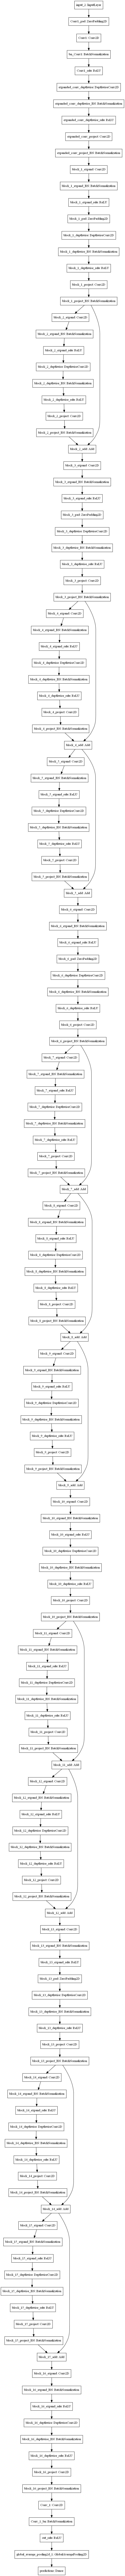

In [8]:
plot_model(model)

In [9]:
#優化器、損失函數，指標函數
model.compile(keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])

In [10]:
#回調函數
log_dir = os.path.join('cifar10','MobileNetV2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq ='epoch')
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + "/MobileNetV2-save.h5", monitor='val_categorical_accuracy', mode='max')

In [11]:
history = model.fit(train_data, initial_epoch = 0, epochs = 50, validation_data = valid_data, callbacks=[model_cbk, model_mckp])

Epoch 1/50
704/704 [==============================] - 200s 284ms/step - loss: 0.4920 - categorical_accuracy: 0.8350 - val_loss: 11.8302 - val_categorical_accuracy: 0.1274
Epoch 2/50
704/704 [==============================] - 202s 286ms/step - loss: 0.2925 - categorical_accuracy: 0.9008 - val_loss: 9.0891 - val_categorical_accuracy: 0.2178
Epoch 3/50
704/704 [==============================] - 198s 281ms/step - loss: 0.2412 - categorical_accuracy: 0.9189 - val_loss: 8.4090 - val_categorical_accuracy: 0.2894
Epoch 4/50
704/704 [==============================] - 201s 285ms/step - loss: 0.2051 - categorical_accuracy: 0.9304 - val_loss: 3.0032 - val_categorical_accuracy: 0.5370
Epoch 5/50
 13/704 [..............................] - ETA: 2:58 - loss: 0.1627 - categorical_accuracy: 0.9435

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model(model_dir + "/MobileNetV2-save.h5")

In [21]:
# 訓練後的評估
print("train_data:")
model.evaluate(train_data)
print("valid_data:")
model.evaluate(valid_data)
print("test_data:")
model.evaluate(test_data)

train_data:
704/704 [==============================] - 53s 75ms/step - loss: 0.0325 - categorical_accuracy: 0.9904
valid_data:
79/79 [==============================] - 6s 74ms/step - loss: 0.4780 - categorical_accuracy: 0.9228
test_data:
157/157 [==============================] - 12s 74ms/step - loss: 0.5327 - categorical_accuracy: 0.9150


[0.5327320098876953, 0.9150000214576721]

In [18]:
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_apply = tfmot.quantization.keras.quantize_apply
quantize_scope = tfmot.quantization.keras.quantize_scope

In [21]:
q_model= quantize_model(model)

#優化器、損失函數，指標函數
q_model.compile(keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])

#回調函數
log_dir = os.path.join('cifar10','q-MobileNetV2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq ='epoch')
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + "/Q-model-MobileNetV2.h5", monitor='val_categorical_accuracy', mode='max')

In [22]:
q_history = q_model.fit(train_data, initial_epoch = 0, epochs=5, validation_data = valid_data, callbacks=[model_cbk, model_mckp])

Epoch 1/5
   2/2813 [..............................] - ETA: 30:01 - loss: 0.6163 - categorical_accuracy: 0.8750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.486966). Check your callbacks.


2813/2813 [==============================] - 1003s 357ms/step - loss: 0.4463 - categorical_accuracy: 0.8506 - val_loss: 1.7322 - val_categorical_accuracy: 0.6314
Epoch 2/5
2813/2813 [==============================] - 1001s 356ms/step - loss: 0.3616 - categorical_accuracy: 0.8779 - val_loss: 1.5465 - val_categorical_accuracy: 0.6804
Epoch 3/5
2813/2813 [==============================] - 1000s 356ms/step - loss: 0.3048 - categorical_accuracy: 0.8987 - val_loss: 0.8114 - val_categorical_accuracy: 0.7884
Epoch 4/5
2813/2813 [==============================] - 999s 355ms/step - loss: 0.2593 - categorical_accuracy: 0.9105 - val_loss: 1.4153 - val_categorical_accuracy: 0.7154
Epoch 5/5
2813/2813 [==============================] - 998s 355ms/step - loss: 0.2236 - categorical_accuracy: 0.9224 - val_loss: 0.5298 - val_categorical_accuracy: 0.8434


In [19]:
# 訓練後的評估
print("train_data:")
q_model.evaluate(train_data)
print("valid_data:")
q_model.evaluate(valid_data)
print("test_data:")
q_model.evaluate(test_data)

train_data:
2813/2813 [==============================] - 307s 109ms/step - loss: 0.0529 - categorical_accuracy: 0.9816
valid_data:
313/313 [==============================] - 34s 108ms/step - loss: 0.4076 - categorical_accuracy: 0.9106
test_data:
625/625 [==============================] - 68s 109ms/step - loss: 0.4578 - categorical_accuracy: 0.8979


[0.4577782154083252, 0.8978999853134155]